# About the project
In this project we will explore the dataset called "Online retail II" which contains data about online retail from 2009 to 2011.
The dataset can be downloaded from [here](https://archive-beta.ics.uci.edu/dataset/502/online+retail+ii).
The dataset originally comes in excel format, but has been transformed into csv files by using the builtin tools of MS excel.


## Defining the schema and loading the data
Let's start the project by defining the paths of the files and the schema. We will then load the files into a dataframe based on the schema.

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType, TimestampType

# Invoice	StockCode	Description	Quantity	InvoiceDate	Price	Customer ID	Country
retail_file_1 = "/Users/madslun/Documents/Programmering/Big data analytics/data/Online retail/2009-2010-online_retail_II.csv"
retail_file_2 = "/Users/madslun/Documents/Programmering/Big data analytics/data/Online retail/2010-2011-online_retail_II.csv"

retail_schema = StructType(fields=[
    StructField("Invoice", IntegerType(), False),
    StructField("StockCode", StringType(), False),
    StructField("Description", StringType(), False),
    StructField("Quantity", IntegerType(), False),
    StructField("InvoiceDate", StringType(), False),
    StructField("Price", DoubleType(), False),
    StructField("Customer ID", IntegerType(), False),
    StructField("Country", StringType(), False),
])
spark = SparkSession.builder.appName("Online-retail").getOrCreate()

df1 = spark.read.schema(retail_schema) \
    .option("header", "true") \
    .option("delimiter", ";") \
    .csv([retail_file_1, retail_file_2])



23/02/08 14:31:27 WARN Utils: Your hostname, Madss-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.202.0.158 instead (on interface en0)
23/02/08 14:31:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/08 14:31:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/08 14:31:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Handling dates
As we defined above, the date format was put into a string format. The reason for this is that we will have to define the format in order to

In [3]:
from pyspark.sql.functions import to_timestamp

df1 = df1.withColumn("Time", to_timestamp("InvoiceDate", "dd.MM.yyyy HH:mm")).drop("InvoiceDate")

## Distribution of countries
Before we start using models to do predictions we will explore what data we are dealing with here. Firstly we will start by looking at the distribution of countries, since this is the data we want to do the prediction on.


45331


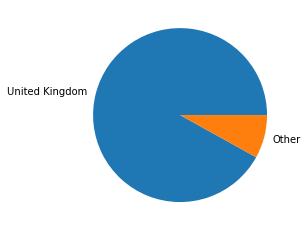

In [4]:
import matplotlib.pyplot as plt

unique_invoices = df1.select("Invoice").distinct().count()
print(unique_invoices)

num_uk_country = df1.where("Country == 'United Kingdom'").count()
other_country = df1.where("Country != 'United Kingdom'")
num_other_country = other_country.select("Country").count()

fig, ax = plt.subplots()
ax.pie([num_uk_country, num_other_country], labels=['United Kingdom', 'Other']
       )

plt.show()


As we saw from the chart above, there is one dominant country in this dataset, and that is UK.


## Price
Let's have a look at the price gap in the sales we are dealing with.

In [22]:
from pyspark.sql.functions import col

max_price = df1.orderBy(col("Price").desc()).select("Price").show(1)
min_price = df1.orderBy(col("Price").asc()).select("Price").show(1)


+-------+
|  Price|
+-------+
|38970.0|
+-------+
only showing top 1 row

+---------+
|    Price|
+---------+
|-53594.36|
+---------+
only showing top 1 row



As we can see here, the lowest number is negative, and even greater in absolute value than the max value.

*Note; I tried plotting this in a histogram, but since the values are so spread apart, the plot only took a long time to render and gave no additional insight.*

## Months
Let's see if there are any noteable distribution within the months of a purchase.

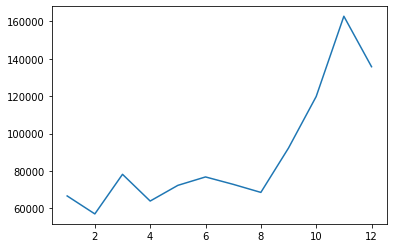

In [23]:
from pyspark.sql.functions import month

sales_by_month = df1.groupby(month('Time')).count().collect()

mapped = dict(sorted(iter(sales_by_month)))
plt.plot((mapped.keys()), mapped.values())

As we can see here the purchases remain pretty stable the first eight months of a year. However, when we approach the autumn/winter months, there is a massive increase. This increase peeks at november, and falls until February.

## Hours
We have determined that there are most purchases in the last months of the year. Let's have a further look and see if there is any pattern as to when the purchases happen during the day.

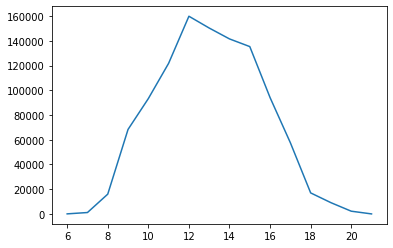

In [24]:
from pyspark.sql.functions import hour

#We see that there are negative numbers here O.o
sales_by_hour = df1.groupby(hour('Time')).count().collect()

fig, ax = plt.subplots()

mapped = dict(sorted(iter(sales_by_hour)))
plt.plot((mapped.keys()), mapped.values())


We see here that there is few purchases happening close to opening and closing times. From 08 to 18, almost all the purchases happen. This peeks around 12, and decreases steadily afterwards.

In [25]:
customer_purchase = df1.groupby(col("Customer ID")).count().collect()
customer_purchase = dict(iter(customer_purchase))

print(sum(customer_purchase.values()) / len(customer_purchase))

179.60137977452464


## Prepare for classifying
Now that we have gained some insight in the dataset we need to prepare it for classifying. We will convert the contries into one-hot encodings, and the time into unix timestamp.

In [26]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import unix_timestamp

df1 = df1.dropna()

# df1 = df1.withColumn("Time", to_timestamp("InvoiceDate", "dd.MM.yyyy HH:mm")).drop("InvoiceDate")

df1 = df1.withColumn('Time', unix_timestamp('Time'))

In [27]:
encoder = StringIndexer(inputCol='Country', outputCol='O-Country')
model = encoder.fit(df1)
df1 = model.transform(df1)

In [28]:
df1.show()

+-------+---------+--------------------+--------+-----+-----------+--------------+----------+---------+
|Invoice|StockCode|         Description|Quantity|Price|Customer ID|       Country|      Time|O-Country|
+-------+---------+--------------------+--------+-----+-----------+--------------+----------+---------+
| 489434|    85048|15CM CHRISTMAS GL...|      12| 6.95|      13085|United Kingdom|1259649900|      0.0|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12| 6.75|      13085|United Kingdom|1259649900|      0.0|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12| 6.75|      13085|United Kingdom|1259649900|      0.0|
| 489434|    22041|"RECORD FRAME 7""...|      48|  2.1|      13085|United Kingdom|1259649900|      0.0|
| 489434|    21232|STRAWBERRY CERAMI...|      24| 1.25|      13085|United Kingdom|1259649900|      0.0|
| 489434|    22064|PINK DOUGHNUT TRI...|      24| 1.65|      13085|United Kingdom|1259649900|      0.0|
| 489434|    21871| SAVE THE PLANET MUG|      24| 1.25|      130

## Selecting features
Let's continue the preparation by creating a vector with the features with a belonging label column. Then we will split the data into training and testing.

In [29]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Invoice', 'Quantity', 'Customer ID', 'Time', 'Price'], outputCol='features')

output = assembler.transform(df1)
processed_data = output.select('features', 'O-Country')
print(processed_data)



DataFrame[features: vector, O-Country: double]


In [30]:
train, test = processed_data.randomSplit([0.8, 0.2])

## Logistic regression
We will start by using a logistic regression classifier and using the training dataset to fit the model. Afterwards we will use the test dataset to test its ability to predict labels. We will have a look at Auc and Accuracy.

In [31]:
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(labelCol='O-Country')

learned = model.fit(train)
pred = learned.transform(test)

23/02/08 14:51:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/08 14:51:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [32]:
pred.summary().show(3)

+-------+-----------------+-------------------+
|summary|        O-Country|         prediction|
+-------+-----------------+-------------------+
|  count|           161486|             161486|
|   mean|0.564909651610666|0.04007158515289251|
| stddev|2.590680835528958|0.22923327568324287|
+-------+-----------------+-------------------+
only showing top 3 rows



In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluate = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="O-Country")
auc = evaluate.evaluate(pred)
print("Auc", auc)

Auc 0.6765731619155396


In [34]:
correct_predictions = pred.where(col("O-Country") == col("prediction")).count()
total = pred.count()

print("Acc", float(correct_predictions) / float(total))

Acc 0.9092429065058272


As we see from the metrics, the model is able to predict quite well. The auc is not particularly high, but it is okay. The acc is quite good.

## Random forest
Now let's use a different model, namely the RandomForestClassifier, to do the same task and measure it in the same metrics.

In [35]:
from pyspark.ml.classification import RandomForestClassifier

model = RandomForestClassifier(labelCol='O-Country')

learned = model.fit(train)
pred = learned.transform(test)

In [36]:
evaluate = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="O-Country")
auc = evaluate.evaluate(pred)
print("Auc", auc)

Auc 0.7961717551238516


In [37]:
correct_predictions = pred.where(col("O-Country") == col("prediction")).count()
total = pred.count()

print("Acc", float(correct_predictions) / float(total))

Acc 0.9204327310107377


We can see that both auc and acc increased compared to the LogisticRegression. Both results is now quite good.

## MLP
Finally, we will try to use a MLP to perform the same task and measure in the same metrics.

*Note; the input layer has to be equal to the amount of faetures, and the output has to be equal to the amount of possible output labels*

In [38]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

model = MultilayerPerceptronClassifier(layers=[5, 10, 15, 20, 25, 30, 35, 41], maxIter=100, labelCol="O-Country")

learned = model.fit(train)
pred = learned.transform(test)

23/02/08 14:52:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/08 14:52:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [39]:
evaluate = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="O-Country")
auc = evaluate.evaluate(pred)
print(auc)

0.5


In [40]:
correct_predictions = pred.where(col("O-Country") == col("prediction")).count()
total = pred.count()

print("Acc", float(correct_predictions) / float(total))

Acc 0.8998984432086992


As we can see from the MLP results, it scores worse on both metrics compared to the 2 previous models.